# Data cleaning
First, load the file `noaa_data.csv` (from the "Data collection" notebook):

In [1]:
import pandas as pd
df = pd.read_csv('noaa_data.csv')
df = df.drop(['Unnamed: 0'], axis=1) # The same is the index, so it's redundant
df.head()

,YEAR,STATE,TOR_F_SCALE
0,1950,OKLAHOMA,F3
1,1950,TEXAS,F1
2,1950,PENNSYLVANIA,F2
3,1950,PENNSYLVANIA,F2
4,1950,PENNSYLVANIA,F0


## Current year
I will drop the rows corresponding to the current year 2022, since data is available only for part of the year:

In [2]:
df = df[df['YEAR'] < 2022]

In [3]:
df.tail()

,YEAR,STATE,TOR_F_SCALE
73671,2021,ILLINOIS,EF1
73672,2021,MISSOURI,EF4
73673,2021,NEW JERSEY,EF0
73674,2021,MISSISSIPPI,EF1
73675,2021,TENNESSEE,EF2


## State names
I will put the state names in the title case:

In [4]:
df['STATE'] = df['STATE'].apply(lambda s: s.title())

In [5]:
df.head()

,YEAR,STATE,TOR_F_SCALE
0,1950,Oklahoma,F3
1,1950,Texas,F1
2,1950,Pennsylvania,F2
3,1950,Pennsylvania,F2
4,1950,Pennsylvania,F0


## Tornado strength — handling missing values
According to the documentation for the data, "TOR_F_SCALE" is the Enhanced Fujita Scale, which describes the strength of the tornado based on the amount and type of damage caused by the tornado. The F-scale of damage will vary in the destruction area; therefore, the highest value of the F-scale is recorded for each event.
* EF0 – Light Damage (40 – 72 mph)
* EF1 – Moderate Damage (73 – 112 mph)
* EF2 – Significant damage (113 – 157 mph)
* EF3 – Severe Damage (158 – 206 mph)
* EF4 – Devastating Damage (207 – 260 mph)
* EF5 – Incredible Damage (261 – 318 mph)

In [6]:
df.TOR_F_SCALE.unique()

array(['F3', 'F1', 'F2', 'F0', 'F4', nan, 'F5', 'EF0', 'EF2', 'EF1',
       'EF3', 'EF4', 'EF5', 'EFU'], dtype=object)

There are some NaN's (most likely empty cells in the original data files) and also 'EFU', which I assume means that the strength is "undetermined". Let's see how many there are:

In [7]:
num_NaN = df["TOR_F_SCALE"].isnull().sum()
print(f'NaN: {num_NaN} ({num_NaN / len(df) * 100:.1f}%)')
num_EFU = (df["TOR_F_SCALE"] == "EFU").sum()
print(f'EFU: {num_EFU} ({num_EFU / len(df) * 100:.1f}%)')
print(f'Total: {num_NaN + num_EFU} out of {len(df)} ({(num_NaN + num_EFU) / len(df) * 100:.1f}%)')

NaN: 1970 (2.7%)
EFU: 652 (0.9%)
Total: 2622 out of 73676 (3.6%)


So, the strength information is missing for about 3.6% of the recorded tornados. The missing data appear only in 1995 or before:

In [8]:
df['EFU'] = df['TOR_F_SCALE'].apply(lambda x: 1 if x == 'EFU' else 0)
df['MISSING'] = df['TOR_F_SCALE'].apply(lambda x: 1 if pd.isnull(x) else 0)
fraction_missing = df.groupby('YEAR').mean()

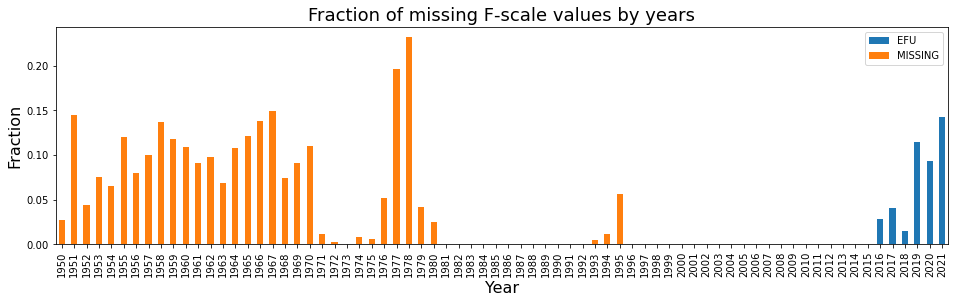

Maximum fraction of 0.232 is observed in year 1978.


In [9]:
import matplotlib.pyplot as plt
# df['NO_TOR_F_SCALE'] = df['TOR_F_SCALE'].apply(lambda x: 1 if pd.isnull(x) or x == 'EFU' else 0)
# fraction_missing = df.groupby('YEAR').mean()
fraction_missing.plot(kind='bar', stacked=True, figsize=(16, 4), legend=True)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Fraction', fontsize=16)
plt.title('Fraction of missing F-scale values by years', fontsize=18)
plt.show()

print(f'Maximum fraction of {fraction_missing.sum(axis=1).max()} is observed in year {fraction_missing.sum(axis=1).idxmax()}.')

Missing values are observed only in or before 1995, while the "EFU" values are found in or after 2016. Since those tornados with missing strength information are likely to be weak, their strengths will be set to 0.  The other the F scale values will be coverted to integers.

In [10]:
import numpy as np
df['Strength'] = [int(s[-1]) if type(s) == str and s[-1] != 'U' else 0 for s in df['TOR_F_SCALE']]
df.drop(['EFU', 'MISSING', 'TOR_F_SCALE'], axis=1, inplace=True)

In [11]:
np.sort(df['Strength'].unique())

array([0, 1, 2, 3, 4, 5])

Here is the distribution of tonado strength:

In [12]:
df['Strength'].value_counts()

0    33931
1    24041
2    10997
3     3445
4     1124
5      138
Name: Strength, dtype: int64

In [13]:
df.columns = [s.title() for s in df.columns]
df

,Year,State,Strength
0,1950,Oklahoma,3
1,1950,Texas,1
2,1950,Pennsylvania,2
3,1950,Pennsylvania,2
4,1950,Pennsylvania,0
...,...,...,...
73671,2021,Illinois,1
73672,2021,Missouri,4
73673,2021,New Jersey,0
73674,2021,Mississippi,1


Save the cleaned data to a .csv file:

In [14]:
df.to_csv('noaa_data_cleaned.csv')